<a href="https://colab.research.google.com/github/Krankile/npmf/blob/main/notebooks/univariate_statistical_forecacst.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

## Kernel setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%%capture
!git clone https://github.com/Krankile/npmf.git
!pip install wandb
!pip install pmdarima

In [6]:
!wandb login

wandb: Currently logged in as: ankile (krankile). Use `wandb login --relogin` to force relogin


In [7]:
import multiprocessing
multiprocessing.cpu_count()

16

## General setup

In [8]:
%%capture
!cd npmf && git pull

import os
import pickle
from collections import defaultdict
from datetime import datetime
from operator import itemgetter

import numpy as np
from numpy.ma.core import outerproduct
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm

import pmdarima as pm

import wandb as wb

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from npmf.utils.colors import main, main2, main3
from npmf.utils.wandb import get_dataset, put_dataset, put_models, get_models
from npmf.utils.data import test_start_pd
from npmf.utils.measurement import mape

In [5]:
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=[main, main2, main3, "black"])
mpl.rcParams['figure.figsize'] = (6, 4)  # (6, 4) is default and used in the paper

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [7]:
np.random.seed(420)

In [27]:
def plot_market_cap(df):
    plt.plot(df.date.to_numpy(), df.market_cap.to_numpy())

# Let's get the data and split into training and testing 😂✨KAWAIII ^^✨



In [30]:
data = get_dataset("stock-oil-final:v4", "master-test")

# Must manually take out ticker VIK.CD and points before 2000
# Should be fixed upstream
data = data[(data.date > "01.01.2000") & (data.ticker != "VIK.CD")]

wandb: Downloading large artifact stock-oil-final:v4, 77.63MB. 1 files... Done. 0:0:0


In [31]:
trn = data[(data.date < test_start_pd)].copy()
tst = data[data.date >= test_start_pd].copy()

tst["obs_number"] = tst.groupby("ticker").date.rank(method='first', ascending=True).astype(int)
tst = tst[tst.obs_number <= 20]

tickers = set(trn.ticker.unique()) & set(tst.ticker.unique())
print("Tickers:", len(tickers))

trn.shape, tst.shape

Tickers: 840


((2490471, 5), (17960, 6))

## Decide the length of lags that should be used for training the ARIMA models

4916

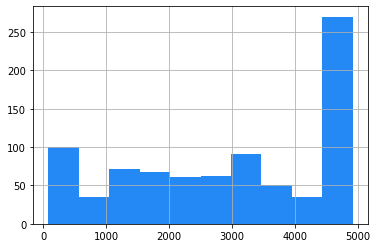

In [32]:
# Measure the length of series for all series
trn.groupby("ticker").count().date.hist()
trn.groupby("ticker").count().date.max()

In [ ]:
# List of lags to test: 1 month, 2 months, 1 quarter, 2 quarters, 3 quarters, 1 year -> 20 years
lags = [20, 40] + list(range(60, 60*4, 60)) + list(range(240, 5000, 240))

len(lags)

25

In [ ]:
# Choose a subset of the 934 tickers to test for
ticker_subset = np.random.choice(np.array(list(tickers)), size=50, replace=False)
len(ticker_subset)

50

In [ ]:
# Create the validation set
traval = trn[trn.ticker.isin(ticker_subset)].copy()
print(traval.shape)
traval["obs_number"] = traval.groupby("ticker").date.rank(method='first', ascending=False).astype(int)

val = traval[traval.obs_number <= 20]
val.head()

(150918, 5)


,ticker,date,market_cap,close_price,currency,obs_number
47432,000985.SZ,2018-12-03,260417147.300793,2.008779,USD,20
47433,000985.SZ,2018-12-04,266893136.824546,2.058733,USD,19
47434,000985.SZ,2018-12-05,262509301.782744,2.024918,USD,18
47435,000985.SZ,2018-12-06,255827774.064171,1.973378,USD,17
47436,000985.SZ,2018-12-07,256325317.533062,1.977216,USD,16


In [ ]:
train = traval[traval.obs_number > 20].copy()
train["obs_number"] = train.groupby("ticker").date.rank(method='first', ascending=False).astype(int)

train.head()

,ticker,date,market_cap,close_price,currency,obs_number
42973,000985.SZ,2000-07-26,310848350.161843,2.39779,USD,4459
42974,000985.SZ,2000-07-27,299053060.041307,2.306804,USD,4458
42975,000985.SZ,2000-07-28,299188346.981665,2.307848,USD,4457
42976,000985.SZ,2000-07-31,295723016.716591,2.281117,USD,4456
42977,000985.SZ,2000-08-01,297543122.191621,2.295157,USD,4455


In [ ]:
def calculate_mean_mapes(ls, tcks):
    mean_mapes = []

    it = tqdm(total=len(ls)*len(tcks))

    for lag in ls:
        it.set_postfix(dict(lag=lag))
        mapes = []
        for ticker in tcks:
            series = train.loc[(train.ticker == ticker) & (train.obs_number <= lag), ["date", "market_cap"]].set_index("date").squeeze()

            mod = pm.arima.AutoARIMA(seasonal=False)
            mod.fit(series)

            forecast = mod.predict(20)
            actual = val.loc[(val.ticker == ticker), ["date", "market_cap"]].set_index("date").squeeze()
            mapes.append(mape(actual, forecast))
            it.update()

        mean_mapes.append(np.mean(mapes))

    return mean_mapes

In [ ]:
# Profile to double check that we've not committed mistakes and that ARIMA is the pundit, time-wise
import cProfile

cmd = lambda: calculate_mean_mapes(lags[:2], ticker_subset[:20])

cProfile.run("calculate_mean_mapes(lags[:2], ticker_subset[:20])")

In [ ]:
mmapes = calculate_mean_mapes(lags[::2], ticker_subset[:20])

100%|██████████| 260/260 [1:25:41<00:00, 19.77s/it, lag=4800]


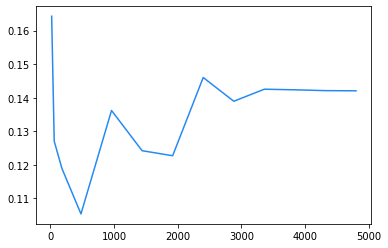

In [ ]:
plt.plot(lags[::2], mmapes);

In [ ]:
# Do a more thorough search around the optimal above
mmapes = calculate_mean_mapes(lags[1:9], ticker_subset)

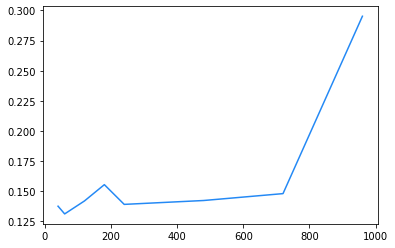

In [35]:
plt.plot(lags[1:9], mmapes);

In [ ]:
# Finding the lag with the lowest loss
min(zip(lags[1:9], mmapes), key=lambda x: x[1])

(60, 0.1310619774505307)

From the above, we can conclude that ARIMA performs best when using the previous 60 datapoints, i.e., around a quarter of data before the month it shall predict.

## Train ARIMA models on last quarter of 2018 🎯

And upload the result to WandB


In [36]:
# Use the above results and get the last quarter of data in the training set
trn = trn[(trn.date >= "2018-10-01")].copy()
print(trn.shape[0])

52496


In [ ]:
trained_models = dict()

In [37]:
for ticker in tqdm(list(tickers)[800:]):

    series = trn.loc[trn.ticker == ticker, ["date", "market_cap"]].set_index("date").squeeze()
    
    mod = pm.arima.AutoARIMA()
    mod.fit(series)

    trained_models[ticker] = mod

100%|██████████| 40/40 [00:35<00:00,  1.12it/s]


In [39]:
filename = "arima-trained-1Q.pickle"
metadata = {
    "type": "ARIMA",
    "n_models": len(trained_models),
}

put_models(filename, trained_models, metadata)

## Predict for first month of 2019

In [38]:
artifact_name = "arima-trained-1Q:latest"
trained_models = get_models(artifact_name)

wandb: Downloading large artifact arima-trained-1Q:latest, 119.94MB. 1 files... Done. 0:0:0


  0%|          | 0/400 [39:18<?, ?it/s, lag=40]


In [40]:
ob_num = list(range(1, 21))
out = dict(ticker=[], market_cap=[], obs_number=[])

for ticker, model in tqdm(trained_models.items()):
    forec = model.predict(20)
    ts = [ticker] * 20

    out["ticker"].extend(ts)
    out["market_cap"].extend(forec)
    out["obs_number"].extend(ob_num)

forec_df = pd.DataFrame(out)

put_dataset(forec_df, "arima-forecast-2019M1.feather", "master-test", type_="forecast")

forec_df

100%|██████████| 840/840 [00:02<00:00, 290.01it/s]


,ticker,market_cap,obs_number
0,1662.T,1.022213e+09,1
1,1662.T,1.022213e+09,2
2,1662.T,1.022213e+09,3
3,1662.T,1.022213e+09,4
4,1662.T,1.022213e+09,5
...,...,...,...
16795,PPS.HN,4.100131e+06,16
16796,PPS.HN,4.077443e+06,17
16797,PPS.HN,4.054756e+06,18
16798,PPS.HN,4.032068e+06,19


In [41]:
a = tst.set_index(["ticker", "obs_number"]).drop(columns=["close_price", "currency", "date"])
f = forec_df.set_index(["ticker", "obs_number"])

errors = ((a - f).abs() / a.abs()).dropna()

In [55]:
# Check sMAPE as well for reference
2*((a - f).abs() / (a.abs() + f.abs())).dropna().groupby("ticker").mean().mean().item()

0.13165705535982128

In [45]:
errors.groupby("ticker").mean().mean().item()

0.11922935124058949

# Forecast for Naïve as well

To establish a baseline

In [46]:
# Need only one value because naïve will predict the same for all future values
last_value = trn.drop_duplicates(subset=["ticker"], keep="last").drop(columns=["close_price", "currency", "date"]).set_index("ticker")

last_value.head()

,market_cap
ticker,
000096.SZ,711445177.642791
000159.SZ,295766554.600941
000440.KQ,37383424.577752
000552.SZ,851522927.496182
000554.SZ,358586694.401957


In [47]:
# MAPE for naïve
errors = ((a - last_value).abs() / a.abs()).dropna()
errors.groupby("ticker").mean().mean().item()

0.08600014724897861